# Journal Profiling Part 3: Funding

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [grants data ](https://docs.dimensions.ai/dsl/datasource-grants.html) for a list of researchers, so to enrich this list with funding-related metrics. 

This tutorial is the third of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the researchers impact metrics dataset previously extracted
* Query the grants API using the researchers IDs, to obtain their total grants and funding amount
* Enrich the original dataset with these new metrics  
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [1]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

DimCli v0.6.8.1 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


### Load previously saved researchers data 

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `2_researchers_impact_metrics.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [2]:
researchers = pd.read_csv(FOLDER_NAME+"/2_researchers_impact_metrics.csv")

In [ ]:
# TIP to speed this up I'm taking only the top 2000 researchers!
# for a full analysis, just comment out the next line
researchers = researchers[:2000]

In [3]:
# note the extra column will be dropped after re-running
researchers.head(5)

researcher_id  pubs               full_name  citations_mean  \
0   ur.0723426172.10    62         Kari Stefansson      107.516129   
1  ur.01277776417.51    45  Unnur Thorsteinsdottir       81.000000   
2  ur.01247426430.47    33     Gudmar Thorleifsson       80.818182   
3  ur.01313145634.66    32         Andres Metspalu      170.562500   
4  ur.01317433110.75    32        Caroline Hayward      136.843750   

   altmetric_mean  last_pub_year  \
0      229.129032           2020   
1      159.555556           2019   
2      170.424242           2019   
3      362.875000           2019   
4      298.468750           2020   

                                                 url  
0  https://app.dimensions.ai/discover/publication...  
1  https://app.dimensions.ai/discover/publication...  
2  https://app.dimensions.ai/discover/publication...  
3  https://app.dimensions.ai/discover/publication...  
4  https://app.dimensions.ai/discover/publication...

## Adding another impact measure: funding 

We want to enhance the reseachers dataset by adding some funding information:

* total amount of funding for each researcher 
* total number of grants 
* funding end date (useful to understand who is going to publish soon)

### We'll have to do it in two steps


**1 Total grants and last grants year can be easy to extract using the 'researchers' source.** For example:

In [4]:
%%dsldf  
search researchers 
    where id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id+last_grant_year+total_grants]

Returned Researchers: 2 (total = 2)


total_grants                 id  last_grant_year
0             0  ur.01277776417.51              NaN
1             8   ur.0723426172.10           2018.0

**2 Aggregated funding needs to be extracted from the `grants` database.** For example:

> NOTE this kind of aggregate query will not return any data if a researcher that has no grants!


In [5]:
%%dsldf 
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 13


id  count     funding
0     ur.0723426172.10      8  17760368.0
1   ur.012662217132.90      2         0.0
2   ur.010520247252.54      1         0.0
3    ur.01121653260.31      1         0.0
4    ur.01127672147.84      1         0.0
5   ur.011316554452.18      1         0.0
6   ur.012167132327.75      1         0.0
7   ur.012237141052.77      1         0.0
8   ur.012455520474.57      1         0.0
9    ur.01274135317.46      1   2592940.0
10  ur.013362317204.29      1         0.0
11  ur.016620004052.08      1         0.0
12     ur.057767065.52      1         0.0

## Next: full data for step 1

What we're gonna do 

1. loop over all researchers (400 at a time) 
2. extract the **tot grants** and **last grants year** information
3. collect all data into a single dataframe 
4. finally, add the data to our 'researchers' spreadsheet 



In [6]:
llist = list(researchers['researcher_id'])
VERBOSE = False
#
#
query = """search researchers 
                where id in {} 
            return researchers[id+last_grant_year+total_grants] limit 1000"""
#
#
out = []
for chunk in progress(list(chunks_of(list(llist), 400))):
    q = dsl.query(query.format(json.dumps(chunk)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df1 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df1))


Researchers used to query:  2000
Researchers returned:  2000


Save the data so that we can use it later, and preview the results.

In [7]:
df1.head(10)

total_grants                  id  last_grant_year
0             0   ur.01201444625.22              NaN
1             0   ur.01063107667.97              NaN
2             0    ur.0612256763.55              NaN
3             0   ur.01307114140.50              NaN
4             0   ur.01310503443.70              NaN
5             0  ur.016674701102.75              NaN
6             1   ur.01217411134.93           2022.0
7             0   ur.01004460445.52              NaN
8             0  ur.014231041057.12              NaN
9             0  ur.015603204663.30              NaN

## Next: full data for step 2

For this part we will do the following steps:

1. loop over all researchers, chunked in groups of 50
2. for each group, query grants matching those researchers IDs. Instead of returning grants data though, we **facet** on researchers and **aggregate funding information**
3. process the researchers data we got, so to keep only the journal authors we are interested in

**NOTE** since we are querying for grants, each query can return many more researchers than the ones we are asking for, as the co-authors of a grant are also matched

Example query:

In [8]:
%%dsldf  
search grants 
    where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] 
return researchers[id] aggregate funding

Returned Researchers: 13


id  count     funding
0     ur.0723426172.10      8  17760368.0
1   ur.012662217132.90      2         0.0
2   ur.010520247252.54      1         0.0
3    ur.01121653260.31      1         0.0
4    ur.01127672147.84      1         0.0
5   ur.011316554452.18      1         0.0
6   ur.012167132327.75      1         0.0
7   ur.012237141052.77      1         0.0
8   ur.012455520474.57      1         0.0
9    ur.01274135317.46      1   2592940.0
10  ur.013362317204.29      1         0.0
11  ur.016620004052.08      1         0.0
12     ur.057767065.52      1         0.0

Here we 'chunk' using a lower number because each query will return more researchers than the ones we ask for (because we are querying 'grants' this time) 

In [9]:
llist = list(researchers['researcher_id'])
VERBOSE = False

#
#
query = """search grants 
            where researchers.id in {} 
           return researchers[id] aggregate funding limit 1000"""
#
#
out = []
for batch in progress(list(chunks_of(llist, 50))):
    q = dsl.query(query.format(json.dumps(batch)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df2 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df2))


Researchers used to query:  2000
Researchers returned:  37442


Save to csv and preview the data

In [10]:
df2.head(10)

id  count      funding
0  ur.011026120037.74     41  123520898.0
1  ur.015704744537.99     37   26811091.0
2  ur.013723776517.34     34  106897589.0
3   ur.01367711150.31     31   74378595.0
4  ur.016704245502.43     31   56429066.0
5   ur.01313145634.66     29   15473267.0
6  ur.010065171457.69     27   18617422.0
7   ur.01033044533.08     27   28243783.0
8   ur.01104262534.26     22  174803375.0
9    ur.0763727005.09     22   89434501.0

## Finally: let's merge the new data into the 'researchers-impact' table

In [11]:
#
# first let's replace all empty values with zeros
#

df1 = df1.fillna(0)
df2 = df2.fillna(0)

#
# helper functions 
#

def grants_and_year_from_id(researcher_id):
  "try/except to prevent some parsing errors."
  try:
    x = int(df1[df1['id'] == researcher_id]['total_grants'])
  except:
    x = 0
  try:
    y = int(df1[df1['id'] == researcher_id]['last_grant_year'])
  except:
    y = 0
  return (x, y)

def total_funding_from_id(researcher_id):
    """Since the bulk querying returned several rows for same researcher (due to various random combinations
    of researcher IDs lists in the query filters), we take the max value."""
    return df2[df2['id'] == researcher_id]['funding'].max()
    
#
# merge the results found into original researchers dataset
#

total_grants, last_grant_year, total_funding  = [], [], []

for i, row in progress(researchers.iterrows(), total=researchers.shape[0]):
    res_id = row['researcher_id']
    data = grants_and_year_from_id(res_id)
    total_grants.append(data[0])
    last_grant_year.append(data[1])
    total_funding.append(total_funding_from_id(res_id))

researchers['total_grants'] = total_grants
researchers['last_grant_year'] = last_grant_year
researchers['total_funding'] = total_funding
#
# finally..
#
print("=======\nResearchers total:",  len(researchers))
researchers.head(10)


Researchers total: 2000


researcher_id  pubs               full_name  citations_mean  \
0    ur.0723426172.10    62         Kari Stefansson      107.516129   
1   ur.01277776417.51    45  Unnur Thorsteinsdottir       81.000000   
2   ur.01247426430.47    33     Gudmar Thorleifsson       80.818182   
3   ur.01313145634.66    32         Andres Metspalu      170.562500   
4   ur.01317433110.75    32        Caroline Hayward      136.843750   
5    ur.0641525362.39    31      Gonçalo R Abecasis      126.548387   
6   ur.01264737414.70    30               Tõnu Esko      153.133333   
7  ur.014377465057.81    28       Benjamin M. Neale      247.250000   
8    ur.0637651205.48    28   Daniel F Gudbjartsson       73.250000   
9   ur.01220453202.22    27      Eleftheria Zeggini       74.222222   

   altmetric_mean  last_pub_year  \
0      229.129032           2020   
1      159.555556           2019   
2      170.424242           2019   
3      362.875000           2019   
4      298.468750           2020   
5      144.290323           2019   
6      346.000000           2020   
7      178.392857           2020   
8      151.964286           2019   
9      207.962963           2019   

                                                 url  total_grants  \
0  https://app.dimensions.ai/discover/publication...             8   
1  https://app.dimensions.ai/discover/publication...             0   
2  https://app.dimensions.ai/discover/publication...             0   
3  https://app.dimensions.ai/discover/publication...            30   
4  https://app.dimensions.ai/discover/publication...             3   
5  https://app.dimensions.ai/discover/publication...            12   
6  https://app.dimensions.ai/discover/publication...             9   
7  https://app.dimensions.ai/discover/publication...             7   
8  https://app.dimensions.ai/discover/publication...             0   
9  https://app.dimensions.ai/discover/publication...             9   

   last_grant_year  total_funding  
0             2018     17760368.0  
1                0            NaN  
2                0            NaN  
3             2022     15473267.0  
4             2024      2836877.0  
5             2023     56939889.0  
6             2021      1605780.0  
7             2023     42380927.0  
8                0            NaN  
9             2021     15612829.0

Save the data / download it

In [12]:
save(researchers, "3_researchers_impact_metrics_and_funding.csv")

## Couple of Dataviz

In [13]:
temp1 = researchers.sort_values(by=["total_funding"], ascending=False)[:100]
temp2 = researchers.sort_values(by=["last_grant_year"], ascending=False)[:200]

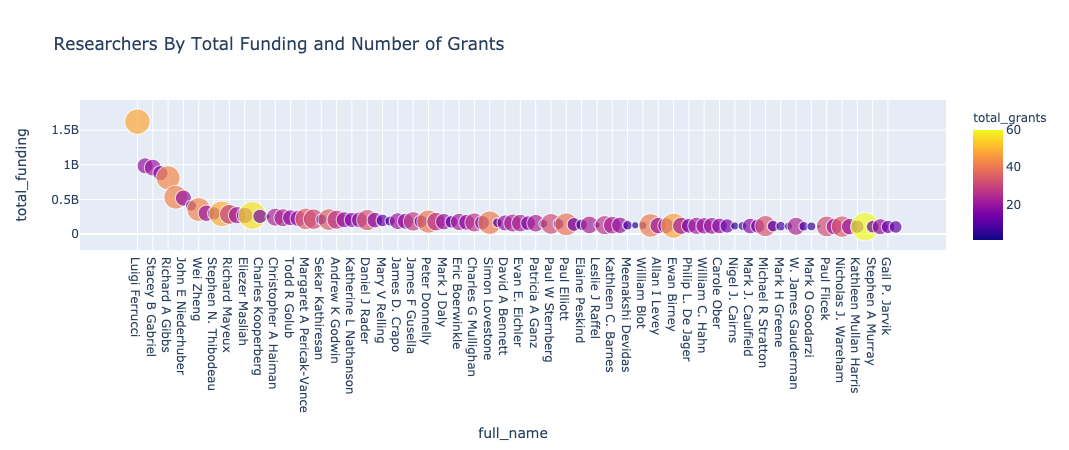

In [14]:
px.scatter(temp1, 
           x="full_name", y="total_funding", 
           hover_name="full_name", 
           size="total_grants", 
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           title="Researchers By Total Funding and Number of Grants")

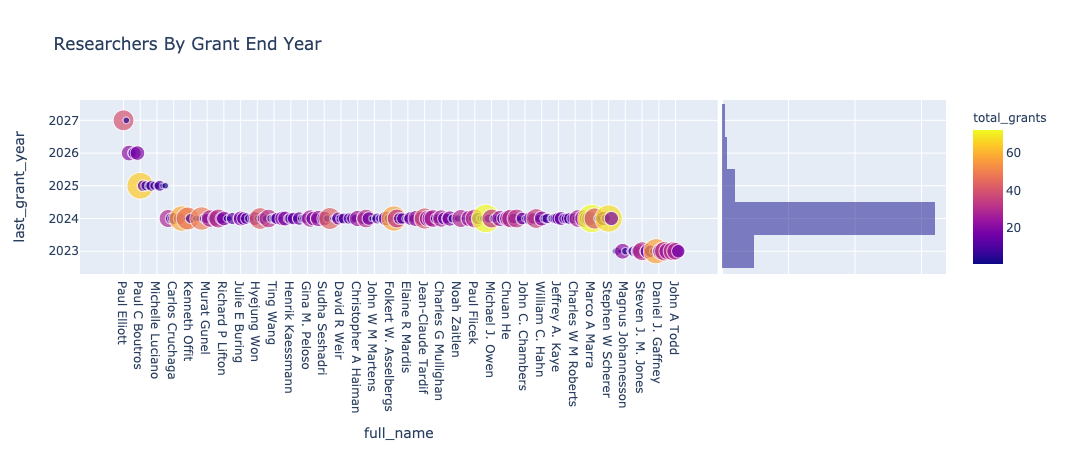

In [15]:
px.scatter(temp2, 
           x="full_name", y="last_grant_year", 
           hover_name="full_name", 
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           marginal_y="histogram",  title="Researchers By Grant End Year")

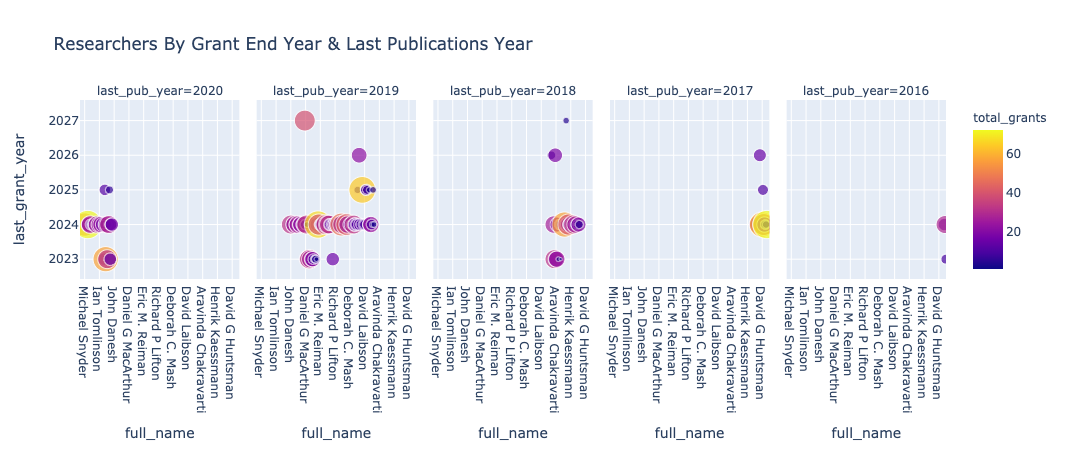

In [16]:
px.scatter(temp2.sort_values("last_pub_year", ascending=False), 
           x="full_name", y="last_grant_year", 
           hover_name="full_name",  
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           facet_col="last_pub_year", 
           title="Researchers By Grant End Year & Last Publications Year")

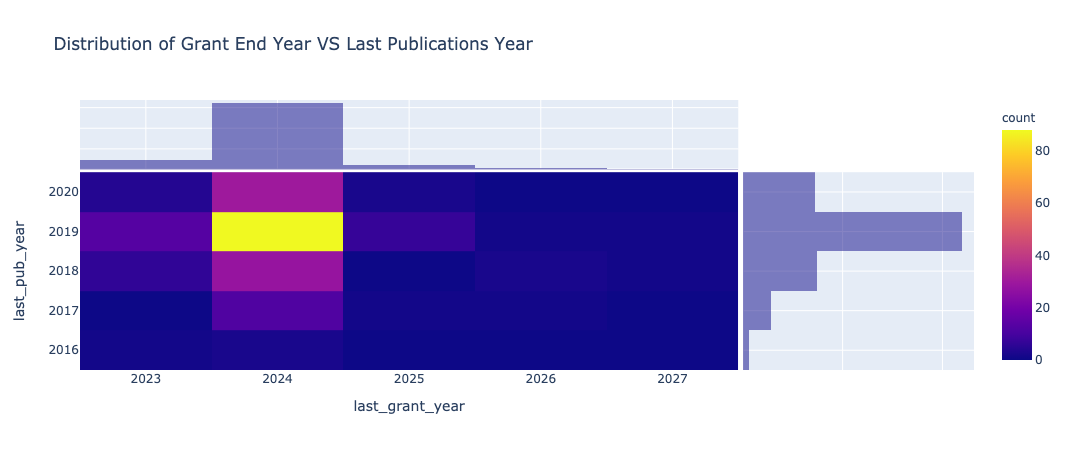

In [17]:
px.density_heatmap(temp2, 
                   x="last_grant_year", y="last_pub_year", 
                   marginal_x="histogram", marginal_y="histogram", 
                   title="Distribution of Grant End Year VS Last Publications Year")